In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from get_utils import return_ignore, get_data, get_dir, get_loss
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
from tdr import build_tdr, project_onto_map, orth_wrt_map
import torch as th
import scipy.stats as stats
import plot as plot
from matplotlib.colors import ListedColormap
from utils import get_initial_loss, get_rate




#%matplotlib qt
#%matplotlib widget
%matplotlib inline

In [2]:
n_model = 40 # number of simulated networks
network_siz = 256
folder_name = f'Sim_fixed_{network_siz}'

labels = ['NF1','FF1','NF2','FF2']



loss_type = 'lateral' # I chose lateral deviation as the loss function


phases = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
palette_colors = {'FF1':(0,0.5,0),'FF2':(0.4,0.4,0.8),'NF1':(0,0,0),'NF2':(0,0,0)}


fontsize_label = 7
fontsize_tick = 7
fontsize_legend = 7

base_dir = os.path.join(os.path.expanduser('~'),'Documents','Data','MotorNet')
save_fig = '/Users/mahdiyar/Dropbox (Personal)/MotorSavings/paper/figures_raw'
if not os.path.exists(save_fig):
    save_fig = os.getcwd()  # Set current directory as save_dir if save_dir doesn't exist

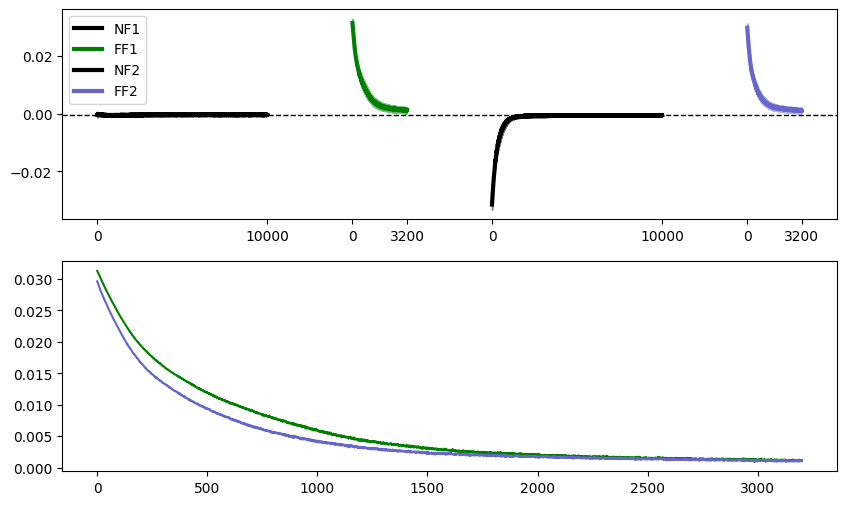

In [3]:
from plot import plot_learning

phases = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
palette_colors = {'FF1':(0,0.5,0),'FF2':(0.4,0.4,0.8),'NF1':(0,0,0),'NF2':(0,0,0)}

ignore = return_ignore(folder_name,n_model) # sometimes some of cpus fail so we want to ignore those models
loss = get_loss(folder_name,n_model,phases,loss_type=loss_type,w=1,target=None,ignore=ignore)

fig, ax = plot_learning(loss,figsize=(10,6),show_saving=True,gap=5000,palette_colors=palette_colors) # (3.8,2.2)

In [4]:
#N_idx = 16 # 16 # time point just before the reach onset
N_idx = 40
F_idx = 59 # 25 # time point just after the reach onset


n_muscle = 6


ignore = return_ignore(folder_name,n_model) # sometimes some of cpus fail so we want to ignore those models
T = pd.DataFrame()

data_tdr = []

for mn in range(n_model):
    model_name = "model{:02d}".format(mn)
    if mn in ignore:
        continue

    # 0. Load weights
    weight_file,_,_= get_dir(folder_name,model_name,'NF1',0)
    W = th.load(weight_file)['fc.weight'].numpy()
    U, S, Vh = np.linalg.svd(W, full_matrices=True)
    V = Vh.T
    P = V[:,:n_muscle] # output potent
    N = V[:,n_muscle:] # output null
    
    # 1. Load data
    U = get_data(folder_name,model_name,phases,n_hidden=network_siz)

    data = []
    force = []
    for i in range(len(U)):
        data.append(np.array(U[i]['all_hidden'])[:,N_idx,:])
        force.append(np.array(U[i]['endpoint_force'])[:,F_idx,:])

    # 1 build TDR
    combined_N = np.vstack(data)
    mean_N = np.mean(combined_N, axis=0)

    X = force[0] # NF1 force 
    N = data[0]-mean_N # NF1 hidden activity

    tdr = build_tdr(X,N)


    # 2 projection onto TDR
    data_p = project_onto_map(data,tdr,remove_mean=True)
    data_tdr.append(data_p)


    # 3 uniform shift from NF1 to FF1
    us = np.mean(data[1]-data[0],axis=0).reshape(-1,1)
    #us_orth_norm = orth_wrt_map(us,tdr)
    us_orth_norm = orth_wrt_map(us,P) 
    #us_orth_norm = us


    proj_onto_us = project_onto_map(data,us_orth_norm,remove_mean=False,mean_all=True)
    u_mean = np.mean(np.array(proj_onto_us),axis=1).ravel()

    d = {
    'mn': [mn] * len(labels),
    'phase': labels,
    'us': u_mean.tolist()
    }
    T = pd.concat([T,pd.DataFrame(d)],ignore_index=True)

[2024-06-10 10:58:37,835] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (8)
[2024-06-10 10:58:37,835] torch._dynamo.convert_frame: [WARNING]    function: '_integrate' (/Users/mahdiyar/Documents/GitHub/MotorNet/motornet/muscle.py:570)
[2024-06-10 10:58:37,835] torch._dynamo.convert_frame: [WARNING]    last reason: ___guarded_code.valid
[2024-06-10 10:58:37,835] torch._dynamo.convert_frame: [WARNING] To log all recompilation reasons, use TORCH_LOGS="recompiles".
[2024-06-10 10:58:37,835] torch._dynamo.convert_frame: [WARNING] To diagnose recompilation issues, see https://pytorch.org/docs/master/compile/troubleshooting.html.
[2024-06-10 10:58:37,942] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (8)
[2024-06-10 10:58:37,942] torch._dynamo.convert_frame: [WARNING]    function: '_joint2cartesian' (/Users/mahdiyar/Documents/GitHub/MotorNet/motornet/skeleton.py:434)
[2024-06-10 10:58:37,942] torch._dynamo.convert_frame: [WA

# Better visualization

In [5]:
sample1 = T.us[T.phase == 'NF1'].to_numpy()
sample3 = T.us[T.phase == 'NF2'].to_numpy()

saving_hidden = sample3-sample1

# Perform paired t-test
t_statistic, p_value = stats.ttest_rel(sample3, sample1)

print("T-statistic:",t_statistic)
print("P-value:",p_value)

T-statistic: 6.348000394220869
P-value: 2.1249647355934596e-07


In [6]:
# Generate the plots
# D = pd.read_csv(base_dir+'/model_loss.csv')
# feature = 'init' # you can select 'init' or 'rate'

# filter_condition = (
#     (D['phase'].isin(['FF1','FF2'])) &
#     (D['size'] == network_siz) &
#     (D['feature'] == feature) # you can select 'init' or 'rate'
# )
# D = D[filter_condition].reset_index(drop=True)
D = pd.DataFrame()

ignore = return_ignore(folder_name,n_model)
loss = get_loss(folder_name,n_model,phases,loss_type=loss_type,w=1,target=None,ignore=ignore)

R = get_rate(loss,w=5,check_fit=False)
I = get_initial_loss(loss)

R['size'] = network_siz
I['size'] = network_siz

T = pd.concat([R,I], ignore_index=True)

D = pd.concat([D,T], ignore_index=True)

D.to_csv(base_dir+'/model_loss2.csv',index=False)

filter_condition = (
    (D['phase'].isin(['FF1','FF2'])) &
    (D['size'] == network_siz) &
    (D['feature'] == 'init') # you can select 'init' or 'rate'
)
D = D[filter_condition].reset_index(drop=True)



sample2 = D.value[D.phase == 'FF1'].to_numpy()
sample4 = D.value[D.phase == 'FF2'].to_numpy()

saving_behav = sample2 - sample4

# Perform paired t-test
t_statistic, p_value = stats.ttest_rel(sample2, sample4)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

stats.ttest_rel(sample2, sample4)

T-statistic: 15.199497500578516
P-value: 1.7214476919312115e-17


TtestResult(statistic=15.199497500578516, pvalue=1.7214476919312115e-17, df=37)

In [7]:
X = saving_behav.reshape(-1, 1)
y = saving_hidden



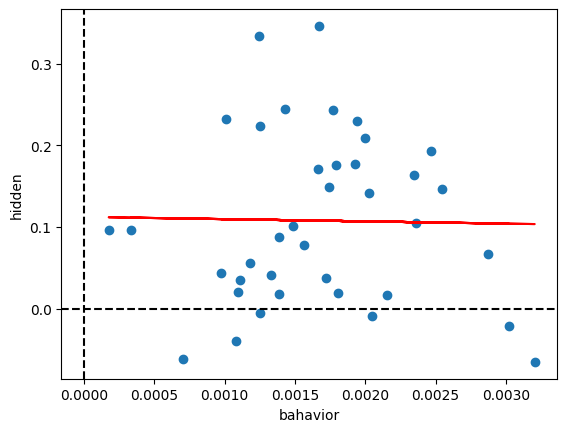

In [8]:
from sklearn.linear_model import LinearRegression, Lasso
import statsmodels.api as sm


# Reshape the data
X = saving_behav.reshape(-1, 1)
y = saving_hidden

#X = sm.add_constant(X)


# Fit Lasso model
lm = LinearRegression(fit_intercept=True)  # Adjust alpha as needed
#lm = Lasso(alpha=1e-9)

lm.fit(X,y)

#lm = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()


#print(lm.summary())



plt.scatter(saving_behav,saving_hidden,label='data')
plt.plot(saving_behav, lm.predict(X), color='red')

plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='--')

plt.xlabel('bahavior')
plt.ylabel('hidden')
#plt.legend()
plt.show()

In [67]:
n_size = len(saving_behav)
n_size

38

In [69]:
from sklearn.utils import resample


n_iterations = 100
n_size = len(saving_behav)
slopes = []

for i in range(n_iterations):
    # Resample the data
    X_resampled, y_resampled = resample(X, y, n_samples=n_size)
    
    # Fit Lasso model to resampled data
    lm = LinearRegression(fit_intercept=True)  # Adjust alpha as needed
    #lm = Lasso(alpha=1e-9)

    lm.fit(X_resampled, y_resampled)
    
    # Store the slope (coefficient)
    slopes.append(lm.coef_[0])

# Calculate the mean and confidence intervals
mean_slope = np.mean(slopes)
lower_ci = np.percentile(slopes, 2.5)
upper_ci = np.percentile(slopes, 97.5)

print(f"Mean slope: {mean_slope}")
print(f"95% Confidence Interval: [{lower_ci}, {upper_ci}]")

# Check if zero is within the confidence interval
if lower_ci <= 0 <= upper_ci:
    print("The slope is not significantly different from zero.")
else:
    print("The slope is significantly different from zero.")


Mean slope: 21.25908336720187
95% Confidence Interval: [-25.39278269405323, 54.251348428915534]
The slope is not significantly different from zero.
